In [1]:
import os
import sys
code_paths = {}
code_paths["repo_name"] = "p5-stress-classifier"
code_paths["package_parent_dir"] = "lib"
    

code_paths["repo_path"] = os.getcwd()
base_dir = os.path.basename(code_paths["repo_path"])
while base_dir != code_paths["repo_name"]:
    code_paths["repo_path"] = os.path.dirname(os.path.abspath(code_paths["repo_path"]))
    base_dir = os.path.basename(code_paths["repo_path"])
    
package_dir = os.path.join(code_paths["repo_path"], "src")
sys.path.insert(0, package_dir)

In [2]:
from stresspred import (code_paths,
                        P5_StressDataLoader, 
                        P5M5DataLoader, 
                        hb_extract, 
                        peak_time_to_rri, 
                        resample_nonuniform, 
                        timestamp_to_samp,
                        samp_to_timestamp,
                        find_local_hb_peaks,
                        get_local_hb_sig,
                        argtop_k)

C:\Users\dbenesch\.conda\envs\stress-requirements\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [3]:
for path in code_paths["neurokit2_paths"]:
    sys.path.insert(0, path)
import neurokit2 as nk

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from json_tricks import dump, dumps, load, loads

In [5]:
out_parent_path_rstr = r"Z:\Shared\Documents\RD\RD2\_Projets\Pascal\P5 In-Ear Biosignal Monitoring\DanielleEersBridge\P5_Stress_label\_gitSave\hb_extraction\unexpected\json_files"
out_parent_path = os.path.join(*out_parent_path_rstr.split("\\"))
if not os.path.exists(out_parent_path):
    os.makedirs(out_parent_path)

In [6]:
min_bpm = 40
max_bpm = 200
interval_min = 60/max_bpm
interval_max = 60/min_bpm
            
for sub_id in [3]:
    out_path = os.path.join(out_parent_path, "out" + str(sub_id) + ".json")
    out = {}
    labels = ["problematic_part_sig"]
    for label in labels:
        out[label] = {}
        for sig_name in ["zephyr_ecg", "ieml", "ti_ppg"]:
            start = 1900
            end = 2050
            sig_info = P5_StressDataLoader(sub_id=sub_id).get_sig(sig_name=sig_name, start_time=start, end_time=end, new_sampling_rate=8000)
            sig_info["peak_time"] = hb_extract(sig=sig_info["sig"], sig_time=sig_info["time"], sig_name=sig_info["name"])
            sig_info["cor_peak_time"] = find_local_hb_peaks(sig_info["peak_time"], 
                                 sig=sig_info["sig"], 
                                 sig_time=sig_info["time"], 
                                 sampling_rate=sig_info["sampling_rate"], 
                                 check_height_outlier=True)
            samp = timestamp_to_samp(sig_info["cor_peak_time"], sig_info["sampling_rate"], sig_info["time"])
            clean_peak_samp = nk.signal_fixpeaks(
                samp,
                sampling_rate=sig_info["sampling_rate"],
                interval_min=interval_min, interval_max=interval_max, method="neurokit")
            clean_peak_time = samp_to_timestamp(clean_peak_samp, sig_time=sig_info["time"])
            cor_clean_peak_time = find_local_hb_peaks(clean_peak_time, 
                     sig=sig_info["sig"], 
                     sig_time=sig_info["time"], 
                     sampling_rate=sig_info["sampling_rate"], 
                     check_height_outlier=True)
            sig_info["cor_clean_peak_time"] = cor_clean_peak_time
            out[label][sig_name] = sig_info 
            with open(out_path, "w") as json_file:
                dump(out, json_file)

C:\Users\dbenesch\eers\git\p5-stress-classifier\src\stresspred\preprocessing.py:177: UserWarning: Warning: the difference between timepoints is not uniform
  warn("Warning: the difference between timepoints is not uniform")
C:\Users\dbenesch\eers\git\p5-stress-classifier\src\stresspred\preprocessing.py:138: UserWarning: Warning: the sample index is less than 0. Changing the sample index to 0.
  warn("Warning: the sample index is less than 0. Changing the sample index to 0.")
C:\Users\dbenesch\eers\git\p5-stress-classifier\src\stresspred\preprocessing.py:177: UserWarning: Warning: the difference between timepoints is not uniform
  warn("Warning: the difference between timepoints is not uniform")


In [7]:
json_paths = [ f.path for f in os.scandir(out_parent_path) if "out" in f.path and ".json" in f.path ]
out_figure_dir_path_rstr = r"Z:\Shared\Documents\RD\RD2\_Projets\Pascal\P5 In-Ear Biosignal Monitoring\DanielleEersBridge\P5_Stress_label\_gitSave\hb_extraction\unexpected\figures"
out_figure_dir_path = os.path.join(*out_figure_dir_path_rstr.split("\\"))
if not os.path.exists(out_figure_dir_path):
    os.makedirs(out_figure_dir_path)

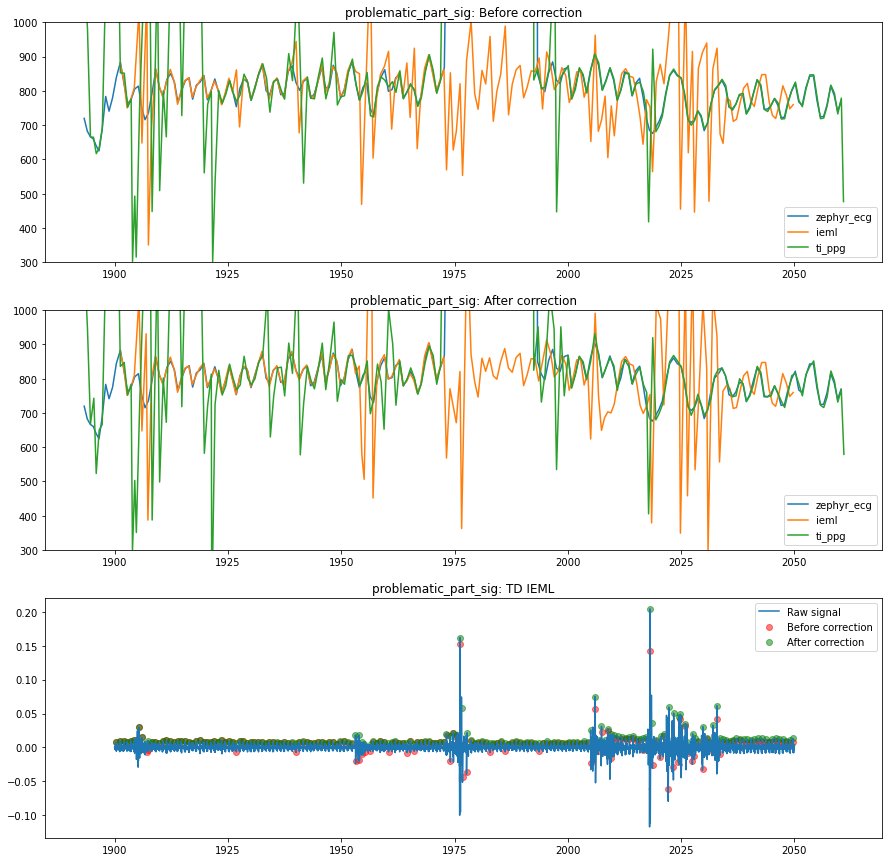

In [8]:
for json_path in json_paths:
    with open(json_path, "r") as json_file:
        data = load(json_file)
    for label in data.keys():
        file_name_start = os.path.splitext(os.path.basename(json_path))[0]
        fig_file_name = file_name_start + "_" + label + "_peak_cor.png"
        fig_file_path = os.path.join(out_figure_dir_path, fig_file_name)
        sig_names = data[label].keys()
        fig = plt.figure(figsize=(15,15))
        ax1 = fig.add_subplot(311)
        for sig_name in sig_names:
            rri, rri_time = peak_time_to_rri(data[label][sig_name]["peak_time"])
            ax1.plot(rri_time, rri)
        ax1.set_ylim([60000/200,60000/60])
        ax1.legend(sig_names)
        ax1.set_title(label + ": Before correction")
        ax2 = fig.add_subplot(312, sharey=ax1, sharex=ax1)   
        for sig_name in sig_names:
            rri, rri_time = peak_time_to_rri(data[label][sig_name]["cor_peak_time"])
            ax2.plot(rri_time, rri)
        ax2.set_title(label + ": After correction")
        ax2.legend(sig_names)
        sig_info = data[label]["ieml"]
        sig=sig_info["sig"]
        sig_time=sig_info["time"]
        sampling_rate=sig_info["sampling_rate"]
        peaks = sig_info["peak_time"]
        new_peaks = sig_info["cor_peak_time"]
        ax3 = fig.add_subplot(313, sharex=ax1)   
        ax3.plot(sig_time, sig)
        samp = timestamp_to_samp(peaks, sampling_rate, sig_time)
        peaks = peaks[samp > 0]
        samp = samp[samp > 0]
        ax3.scatter(peaks,
                    sig[samp], color="red", alpha=0.5)
        samp = timestamp_to_samp(new_peaks, sampling_rate, sig_time)
        new_peaks = new_peaks[samp > 0]
        samp = samp[samp > 0]
        ax3.set_title(label + ": TD IEML")
        ax3.scatter(new_peaks,
                    sig[samp], color="green", alpha=0.5)
        ax3.legend(["Raw signal","Before correction", "After correction"])
        plt.savefig(fig_file_path)
        plt.show()

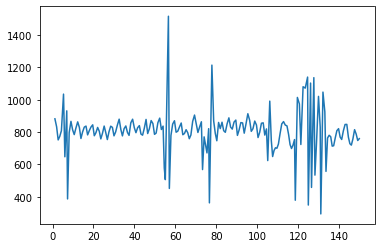

In [9]:
rri, rri_time = peak_time_to_rri(samp/8000)
plt.plot(rri_time, rri)

In [10]:
samp/8000

array([  0.293   ,   1.175   ,   2.007625,   2.759375,   3.5325  ,
         4.341   ,   5.375625,   6.023   ,   6.954375,   7.3415  ,
         8.138375,   9.00475 ,   9.818625,  10.603125,  11.428125,
        12.29125 ,  13.11925 ,  13.87975 ,  14.68075 ,  15.5115  ,
        16.348625,  17.131375,  17.94    ,  18.771125,  19.616   ,
        20.3935  ,  21.1895  ,  22.01825 ,  22.823625,  23.581625,
        24.373625,  25.210875,  26.006875,  26.76075 ,  27.562625,
        28.399125,  29.228375,  30.00525 ,  30.806   ,  31.648875,
        32.52875 ,  33.34525 ,  34.121875,  34.94325 ,  35.781125,
        36.578875,  37.358625,  38.215875,  39.0955  ,  39.922625,
        40.719   ,  41.546   ,  42.386   ,  43.173875,  43.954875,
        44.777375,  45.655625,  46.44675 ,  47.267375,  48.138625,
        48.99175 ,  49.77775 ,  50.57175 ,  51.429875,  52.316125,
        53.13225 ,  53.969125,  54.547375,  55.05375 ,  56.5695  ,
        57.021375,  57.8005  ,  58.65025 ,  59.520375,  60.319